# Model Evaluation

## Import Modules

In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

## RunParameters Class

In [2]:
class RunParameters:
    '''classe che gestisce i parametri della run'''
    
    def __init__(self, out_dir: str, ndir=0, ntoy=40, magic=0):
        '''init: imposto il nome della cartella di output, genero il nome della cartella contenente il file e cerco il file'''
        
        self.out_dir = out_dir
        self.folder_name = os.listdir(self.out_dir+f'/{magic}/')[ndir]
        self.fname = [name for name in os.listdir(self.out_dir+f'/{magic}/'+self.folder_name) if f'_toy{ntoy}_t.txt' in name][0]
        
        return
    
    def fetch_parameters(self) -> list:
        '''uso il nome del file e della cartella per estrarre i parametri della run'''
        
        self.check_point_t = int(self.fname.split("patience", 1)[1].split("_", 1)[0])
        self.toys = int(self.fname.split("toy", 1)[1].split("_", 1)[0])
        self.ref = (self.fname.split("_")[2]).split("ref")[1]
        self.bkg = (self.fname.split("_")[3]).split("bkg")[1]
        self.sig = (self.fname.split("_")[4]).split("sig")[1]
        self.w_clip = self.folder_name.split('wclip',1)[1]
        self.latent = int(self.folder_name.split("latent", 1)[1].split("_", 1)[0])
        self.layers = int(self.folder_name.split("layers", 1)[1].split("_", 1)[0])
        self.epochs = int(self.folder_name.split('epochs',1)[1].split('_')[0])
        
        self.parameters = [self.toys, self.w_clip, self.epochs, self.check_point_t, self.ref, self.bkg, self.sig, self.latent, self.layers]
        
        return self.parameters
    
    def print_parameters(self):
        '''stampo i parametri per controllare corrispondano alla run'''
        
        print('\nFolder name: ' + self.folder_name)
        print('File name: ' + self.fname)
        
        print(f'\nParameters:                                              \
                        \n Toys:          {self.toys}                      \
                        \n Latent space:  {self.latent}                    \
                        \n Layers:        {self.layers}                    \
                        \n W_clip:        {self.w_clip}                    \
                        \n Epochs:        {self.epochs}                    \
                        \n Check_point_t: {self.check_point_t}             \
                        \n Ref, Bkg, Sig: {self.ref} {self.bkg} {self.sig} \n'
             )
        
        return  
    
    def fetch_file(self) -> str:
        '''genero il nome completo del file contenente il t finale'''
        
        self.tfile = f'1D_patience{self.check_point_t}_ref{self.ref}_bkg{self.bkg}_sig{self.sig}\
        _epochs{self.epochs}_latent{self.latent}_layers{self.layers}_wclip{self.w_clip}\
        /1D_patience{self.check_point_t}_ref{self.ref}_bkg{self.bkg}_sig{self.sig}_toy{self.toys}_t.txt'
        
        self.tfile = self.tfile.replace(' ', '')
        
        return self.tfile
    
    def fetch_history(self) -> str:
        '''genero il nome completo del file contenente il t per ogni checkpoint'''
        
        self.thistory = f'1D_patience{self.check_point_t}_ref{self.ref}_bkg{self.bkg}_sig{self.sig}\
        _epochs{self.epochs}_latent{self.latent}_layers{self.layers}_wclip{self.w_clip}\
        /1D_patience{self.check_point_t}_ref{self.ref}_bkg{self.bkg}_sig{self.sig}_toy{self.toys}_history{self.check_point_t}.h5'
        
        self.thistory = self.thistory.replace(' ', '')
        
        return self.thistory

## T Distribution Class

In [23]:
class TDist:
    '''classe che gestisce la distribuzione dei t'''
    
    def __init__(self, dof, bins, toys, epochs, check_point_t, out_dir, tfile, thistory, save_flag):
        '''init: imposto parametri importanti della run e i file di interesse'''
        
        self.dof = dof
        self.bins = bins
        self.epochs = epochs
        self.check_point_t = check_point_t
        self.toys = toys
        self.OUT_PATH = out_dir
        self.OUT_FILE_t = tfile
        self.OUT_FILE_t_history = thistory
        self.save_flag = save_flag
        
        return
    
    
    def plotOutPath(self):
        path = '/lustre/cmswork/nlai/PLOTS/NPL_1D/MODEL_EVALUATION/'
        rPar = RunParameters(self.OUT_PATH, 0, self.toys)
        toys, w_clip, epochs, check_point_t, ref, bkg, sig, latent, layers = rPar.fetch_parameters()
        
        pngfile = f'1D_patience{check_point_t}_ref{ref}_bkg{bkg}_sig{sig}\
        _epochs{epochs}_latent{latent}_layers{layers}_wclip{w_clip}_toy{toys}'
        
        pngfile = pngfile.replace(' ', '')
        
        self.pngpath = path + pngfile
        
        return self.pngpath
    
    
    def getT(self):
        '''ciclo su tutti i file per prendere tutti i t e tutte le history'''
        
        self.t_list=[]
        self.t_list_history=[]
        counter=0
        preview=0
        for i in range(self.toys-preview):
            
            file_name = self.OUT_PATH + f'/{i}/' + self.OUT_FILE_t
            if os.path.isfile(file_name):
                f = open(file_name, "r")
                self.t_list.append(float(f.readline()[:-1]))
                f.close()
                #print(i)
                if np.logical_not(np.isnan(self.t_list[-1])):
                    counter += 1
                    
            history_name = self.OUT_PATH + f'/{i}/' + self.OUT_FILE_t_history
            if os.path.isfile(history_name):
                f = h5py.File(history_name, "r")
                try:
                    self.t_list_history.append(-2*np.array(f.get('loss')))
                except: print('Problem with toy ', i)
                f.close()
                
        self.t_list=np.array(self.t_list)
        self.t_list_history=np.array(self.t_list_history)
        
        print(f"\nToys at disposal/Total toys: {counter}/{self.toys-preview}")
        
        return 
    
    
    def computeMedian(self):
        '''calcolo la mediana per un rapido controllo di compatibilità'''
        
        median_t = np.median(self.t_list)
        print("\nMedian t distribution: ", median_t)
        
        p_list = np.sum([1/(len(self.t_list)) for x in self.t_list if x>median_t])
        
        print(
            f"Median p-value: {p_list :.4f}\
            Median significance: {scipy.stats.norm.ppf(1-p_list):.4f}\
            from t list"
        )
        
        print(
            f"Median p-value: {scipy.stats.chi2.sf(median_t, df=self.dof):.4f}\
            Median significance: {scipy.stats.norm.ppf(1-scipy.stats.chi2.sf(median_t, df=self.dof)):.4f}\
            from chi2 distribution" 
        ) 
        
        return
    
    
    def change_legend(self, ax, new_loc, fontsize, titlesize, **kws):
        '''funzione per modificare posizione e font size della legenda generata da seaborn'''

        old_legend = ax.legend_
        handles = old_legend.legendHandles
        labels = [t.get_text() for t in old_legend.get_texts()]
        title = old_legend.get_title().get_text()

        ax.legend(handles, labels, loc=new_loc, title=title, fontsize=fontsize, title_fontsize=titlesize, frameon = True, fancybox = False, framealpha = 0.5, **kws)
    
        return
    
    def plotterLayout(self, ax, title: str, titlefont: int, xlabel: str, ylabel: str, labelfont: int, xlimits=[], ylimits=[]):
        
        if xlimits:
            ax.set_xlim(xlimits[0], xlimits[1])
        if ylimits:
            ax.set_ylim(ylimits[0], ylimits[1])
            
        ax.set_title(title, fontsize=titlefont)
        
        ax.set_xlabel(xlabel, fontsize = labelfont)
        ax.set_ylabel(ylabel, fontsize = labelfont)
        
        # sistemo i ticks
        ax.tick_params(axis = 'both', which = 'major', labelsize = 14, direction = 'out', length = 5)
        
        return
    
    
    def plotTdist(self, train_dist):
        '''grafico della distribuzione dei t'''
        
        # gestione del plot range
        XMIN = 0
        if max(self.t_list) >= 3*self.dof:
            XMAX = max(self.t_list) + min(self.t_list) 
        elif max(self.t_list) < 3*self.dof:
            XMAX = 3*self.dof
        
        XLIM = [XMIN, XMAX]
          
        # creo la griglia lungo x
        XGRID = np.linspace(XMIN, XMAX, 500)
        
        # numero di bin da utilizzare
        BINS = self.bins
        
        # calcolo p-val e Z della mediana
        self.tobs_median_pval = scipy.stats.chi2.sf(np.median(self.t_list[:]), df=self.dof)
        self.tobs_median_sig = np.abs(scipy.stats.norm.ppf(1-self.tobs_median_pval))
        
        # creo figure&axes
        fig, ax = plt.subplots(figsize=(12,7))
        
        ax.axvline(x=np.median(self.t_list[:]), 
                   color='red', linestyle='solid', linewidth=5, alpha=0.6, 
                   label=f'median: {np.median(self.t_list[:])}', zorder=6)
        
         # istogramma della distrubuzione dei t
        ax = sns.histplot(x=self.t_list, bins=BINS, 
                          stat='density', element='bars', fill=True, color='#FFCDAD', edgecolor='#FF6500',
                          label='data t distribution', zorder=4)
        
        # parte di codice per aggiungere l'incertezza ai bin 
        hist, bin_edges = np.histogram(self.t_list, density=True, bins=BINS)
        binswidth = bin_edges[1]-bin_edges[0]
        central_points = []
        for i in range(0, len(bin_edges)-1):
            half = (bin_edges[i] + bin_edges[i+1])/2
            central_points.append(half)
        # calcolo dell'incertezza dei bin  
        err = np.sqrt(hist/(self.t_list.shape[0]*binswidth))
        # grafico delle incertezze sui bin 
        ax.errorbar(central_points, hist, yerr = err, color='#FF6500', marker='o', ls='', zorder=5)
        
        # istogramma della distribuzione del reference
        ax = sns.histplot(x=train_dist, bins=BINS, 
                          stat='density', element='bars', fill=True, color='#aadeff', edgecolor='#009cff',  
                          label='reference t distribution', zorder=1)
        
        # parte di codice per aggiungere l'incertezza ai bin 
        hist, bin_edges = np.histogram(train_dist, density=True, bins=BINS)
        binswidth = bin_edges[1]-bin_edges[0]
        central_points = []
        for i in range(0, len(bin_edges)-1):
            half = (bin_edges[i] + bin_edges[i+1])/2
            central_points.append(half)
        # calcolo dell'incertezza dei bin  
        err = np.sqrt(hist/(train_dist.shape[0]*binswidth))
        # grafico delle incertezze sui bin 
        ax.errorbar(central_points, hist, yerr = err, color='#009cff', marker='o', ls='', zorder=2)
        
        # grafico della distribuzione teorica del chi2
        ax.plot(XGRID,scipy.stats.chi2.pdf(XGRID, df=self.dof), 
                color='#009cff', linestyle='solid', linewidth=5, alpha=0.6, 
                label=f'theoretical distribution, dof: {self.dof}', zorder=3)
        
        self.plotterLayout(ax=ax, xlimits=XLIM, title='t distribution', titlefont=18, xlabel='t', ylabel='density', labelfont=16)
        
        # gestione della legenda
        ax.legend()
        handles, labels = ax.get_legend_handles_labels()
        ax.legend([handles[idx] for idx in [2, 3, 0, 1]], [labels[idx] for idx in [2, 3, 0, 1]])
        self.change_legend(ax=ax, new_loc="upper right", fontsize=14, titlesize=16)
        
        fig.tight_layout()
        if self.save_flag:
            fig.savefig(self.plotOutPath()+'_distribution.png', dpi = 300, facecolor='white')
        plt.show()
        return 
    
    
    def plotThistory(self):
        '''grafico della storia dei t'''
        
        XMIN = 0
        XMAX = self.epochs
        
        YMIN = 0
        if max(self.t_list) >= 3*self.dof:
            YMAX = max(self.t_list) + min(self.t_list) 
        elif max(self.t_list) < 3*self.dof:
            YMAX = 3*self.dof
            
        XLIM = [XMIN, XMAX]
        YLIM = [YMIN, YMAX]
        
        fig, ax = plt.subplots(figsize=(12,7))
        
        x_tics = np.array(range(self.epochs))
        x_tics = x_tics[x_tics % self.check_point_t == 0]
        
        for i in range(len(self.t_list_history)):
            ax.plot(x_tics[1:],self.t_list_history[i][1:])
            
        self.plotterLayout(ax=ax, xlimits=XLIM, ylimits=YLIM, title='t history', titlefont=18, xlabel='training epoch', ylabel='t', labelfont=16)
        
        fig.tight_layout()
        if self.save_flag:
            fig.savefig(self.plotOutPath()+'_history.png', dpi = 300, facecolor='white')
        plt.show()
        return
    
    
    def plotQuantilesEvo(self):
        '''grafico dell'evoluzione dei quantili della distribuzione dei t'''
        
        XMIN = 0
        XMAX = self.epochs
        
        YMIN = 0
        if max(self.t_list) >= 3*self.dof:
            YMAX = max(self.t_list) + min(self.t_list) 
        elif max(self.t_list) < 3*self.dof:
            YMAX = 3*self.dof
        
        XLIM = [XMIN, XMAX]
        YLIM = [YMIN, YMAX]
        
        fig, ax = plt.subplots(figsize=(12,7))
        
        x_tics = np.array(range(self.epochs))
        x_tics = x_tics[x_tics % self.check_point_t == 0]
        
        quantile_list = [0.05,0.25,0.50,0.75,0.95]
        color_list = ['#ff0000', '#00ff00', '#0080ff', '#ff8000', '#ff00ff']
        th_quantile_position = [scipy.stats.chi2.ppf(i,df=self.dof) for i in quantile_list]
        t_quantile = np.quantile(self.t_list_history, quantile_list, axis=0)
        
        for i in range(len(quantile_list)):
            ax.plot(x_tics[1:], t_quantile[i][1:], 
                    color = color_list[i], linestyle='solid', linewidth = 3, 
                    label = format(quantile_list[i], '1.2f'))
            ax.plot(x_tics[-1], th_quantile_position[i], marker='X', markersize = 15,
                    color = color_list[i])
            ax.hlines(y=th_quantile_position[i], xmin = XMIN, xmax = XMAX, 
                      color = color_list[i], linestyle='dashed', linewidth = 3, alpha = 0.5, 
                    label = 'theoretical ' + format(quantile_list[i], '1.2f'))
        
        self.plotterLayout(ax=ax, xlimits=XLIM, ylimits=YLIM, title='t quantiles evolution', titlefont=18, xlabel='training epoch', ylabel='t', labelfont=16)
  
        ax.legend(title = 'Quantiles', ncol = 2)
        self.change_legend(ax=ax, new_loc="upper right", fontsize=14, titlesize=16)
        ax.legend(title = 'Quantiles', ncol = 2)
        
        fig.tight_layout()
        if self.save_flag:
            fig.savefig(self.plotOutPath()+'_quantiles.png', dpi = 300, facecolor='white')
        plt.show()
        return
    
    
    def plotChi2History(self):
        '''grafico andamento del chi2 per epoche'''
        
        self.t_chi2_history = []
        bin_number = self.bins 
        
        for counter in range(10, self.t_list_history.shape[1]): 
            # binning della distribuzione dei t per ogni checkpoint
            t_hist, binedges = np.histogram(self.t_list_history[:, counter], bins=bin_number, density=False) 
            # cerco il centro di ciascun bin
            bincenter = np.array([(binedges[i+1]+binedges[i])/2 for i in range(len(t_hist))])
            # calcolo la larghezza dei bin
            bin_width = binedges[1]-binedges[0]
            # calcolo l'area dell'istogramma
            area_hist = bin_width*self.toys
            # calcolo l'area della distribuzione teorica sotto l'istogramma
#             area_dist = area_hist*scipy.integrate.quad(lambda x: scipy.stats.chi2.pdf(x, df=self.dof), binedges[0], binedges[-1])[0]
            # calcolo l'altezza teorica di ciascun bin
#             th_bins = np.array([area_dist*scipy.stats.chi2.pdf(b_center, df=self.dof) for b_center in bincenter])   
            th_bins = np.array([area_hist*scipy.stats.chi2.pdf(b_center, df=self.dof) for b_center in bincenter]) 
            # calcolo il chi2
            self.t_chi2_history.append( np.sum( (t_hist-th_bins)**2/th_bins, axis=0 )  ) 
    
        XMIN = 0
        XMAX = self.epochs
        
        XLIM = [XMIN, XMAX]

        fig, ax = plt.subplots(figsize=(12,7))

        x_tics = np.array(range(self.epochs))
        x_tics = x_tics[x_tics % self.check_point_t == 0][10:]

        
        ax.plot(x_tics[:], self.t_chi2_history[:], color='#009cff', linestyle='solid', linewidth=3, alpha=1, 
                label=fr'$\chi^2$ final value: {self.t_chi2_history[-1]:.3f}')
        
        self.plotterLayout(ax=ax, xlimits=XLIM, title=r'$\chi^2$ evolution', titlefont=18, xlabel='training epoch', ylabel=r'$\chi^2$', labelfont=16)
        ax.set_yscale('log')
        
        ax.legend()
        self.change_legend(ax=ax, new_loc="upper right", fontsize=14, titlesize=16)
        
        fig.tight_layout()
        if self.save_flag:
            fig.savefig(self.plotOutPath()+'_chi2.png', dpi = 300, facecolor='white')
        plt.show()

        return
    
    
    def plotChi2Compatibility(self):
        '''andamento compatibilità del chi2 con i gradi di libertà per epoche'''
        
        # calcolo la compatibilità come chi_nu/nu
        self.t_chi2_compatibility = np.array(self.t_chi2_history)/(self.bins-1)
    
        XMIN = 0
        XMAX = self.epochs
        
        XLIM = [XMIN, XMAX]

        fig, ax = plt.subplots(figsize=(12,7))

        x_tics = np.array(range(self.epochs))
        x_tics = x_tics[x_tics % self.check_point_t == 0][10:]
        
        ax.plot(x_tics[:], self.t_chi2_compatibility[:], color='#009cff', linestyle='solid', linewidth=3, alpha=1, 
                label=fr'$\chi^2 / \nu$ final value: {self.t_chi2_compatibility[-1]:.3f}'
               )
        
        self.plotterLayout(ax=ax, xlimits=XLIM, title='compatibility evolution', titlefont=18, xlabel='training epoch', ylabel=r'$\chi^2 / \nu$', labelfont=16)
        
        ax.legend()
        self.change_legend(ax=ax, new_loc="upper right", fontsize=14, titlesize=16)
        
        fig.tight_layout()
        if self.save_flag:
            fig.savefig(self.plotOutPath()+'_compatibility.png', dpi = 300, facecolor='white')
        plt.show()
        
        return
    
    
    def plotPValHistory(self):
        '''andamento del pvalue del chi2 per epoche'''
        
        self.pvalue_history = scipy.stats.chi2.sf(self.t_chi2_history[:], df=self.bins-1) 

        XMIN = 0
        XMAX = self.epochs
        YMIN = 0
        YMAX = 1.2
        
        XLIM = [XMIN, XMAX]
#         YLIM = [YMIN, YMAX]

        fig, ax = plt.subplots(figsize=(12,7))

        x_tics = np.array(range(self.epochs))
        x_tics = x_tics[x_tics % check_point_t == 0][10:]
#         y_tics = np.array( np.arange(0, 1.1, 0.1) )
        
        ax.plot(x_tics[:], self.pvalue_history[:], color='#009cff', linestyle='solid', linewidth=3, alpha=1, 
                label=f'p-val final value: {self.pvalue_history[-1]:.3f}')
        
        self.plotterLayout(ax=ax, xlimits=XLIM, title='p-value evolution', titlefont=18, xlabel='training epoch', ylabel='p-value', labelfont=16)
#         ax.set_yticks(y_tics)
        
        ax.legend()
        self.change_legend(ax=ax, new_loc="upper right", fontsize=14, titlesize=16)
        
        fig.tight_layout()
        if self.save_flag:
            fig.savefig(self.plotOutPath()+'_pvalue.png', dpi = 300, facecolor='white')
        plt.show()
        
        return
    
    
    def plotSignificanceHistory(self):
        '''andamento della significanza del chi2 per epoche'''
        
        self.significance_history=np.abs(scipy.stats.norm.ppf(1-self.pvalue_history[:]))

        XMIN = 0
        XMAX = self.epochs
#         YMIN = 0
#         YMAX = max(self.significance_history)+min(self.significance_history)

        XLIM = [XMIN, XMAX]

        fig, ax = plt.subplots(figsize=(12,7))

        x_tics = np.array(range(self.epochs))
        x_tics = x_tics[x_tics % check_point_t == 0][10:]
#         y_tics = np.array( np.arange(0, 1.1, 0.1) )
        
        ax.plot(x_tics[:], self.significance_history[:], color='#009cff', linestyle='solid', linewidth=3, alpha=1, 
                label=f'Z final value: {self.significance_history[-1]:.3f}')
        
        self.plotterLayout(ax=ax, xlimits=XLIM, title='significance evolution', titlefont=18, xlabel='training epoch', ylabel='Z', labelfont=16)
        
        ax.legend()
        self.change_legend(ax=ax, new_loc="upper right", fontsize=14, titlesize=16)
        
        fig.tight_layout()
        if self.save_flag:
            fig.savefig(self.plotOutPath()+'_significance.png', dpi = 300, facecolor='white')
        plt.show()
        
        return
    
    
    def plotSignificanceToyhistory(self):
        '''grafico della storia della significanza per ogni toy'''
        
        XMIN = 0
        XMAX = self.epochs
        
        XLIM = [XMIN, XMAX]
        
#         YMIN = 0
#         if max(self.t_list) >= 3*self.dof:
#             YMAX = max(self.t_list) + min(self.t_list) 
#         elif max(self.t_list) < 3*self.dof:
#             YMAX = 3*self.dof
        
        fig, ax = plt.subplots(figsize=(12,7))
        
        x_tics = np.array(range(self.epochs))
        x_tics = x_tics[x_tics % self.check_point_t == 0]
        
        for i in range(len(self.t_list_history)):
            ax.plot(x_tics[1:], np.abs(scipy.stats.norm.ppf(1-scipy.stats.chi2.sf(self.t_list_history[i][1:], df=self.dof))))
            
        self.plotterLayout(ax=ax, xlimits=XLIM, title='significance history per toy', titlefont=18, xlabel='training epoch', ylabel='Z', labelfont=16)
        
        fig.tight_layout()
        if self.save_flag:
            fig.savefig(self.plotOutPath()+'_significance_history.png', dpi = 300, facecolor='white')
        plt.show()
        return
    
    
    def plotSignificanceToyDistribution(self):
        '''grafico della storia della significanza per ogni toy'''

        self.significance_dist = np.abs(scipy.stats.norm.ppf(1-scipy.stats.chi2.sf(self.t_list[:], df=self.dof)))

        fig, ax = plt.subplots(figsize=(12,7))
        
        ax = sns.histplot(x=self.significance_dist, bins=self.bins, 
                          stat='density', element='bars', fill=True, color='#aadeff', edgecolor='#009cff', 
                          label='significance distribution')
        
        self.plotterLayout(ax=ax, title='significance distribution', titlefont=18, xlabel='Z', ylabel='density', labelfont=16)
            
        fig.tight_layout()
        if self.save_flag:
            fig.savefig(self.plotOutPath()+'_significance_distribution.png', dpi = 300, facecolor='white')
        plt.show()
        return
    
    def plotMedianHistory(self):
        '''andamento della mediana'''
        
        self.median_history = np.median(self.t_list_history, axis=0)
        
        th_median = scipy.stats.chi2.median(df=self.dof)
        
        XMIN = 0
        XMAX = self.epochs
        
        YMIN = 0
        if max(self.median_history) >= 3*self.dof:
            YMAX = max(self.median_history) + min(self.median_history) 
        elif max(self.median_history) < 3*self.dof:
            YMAX = 3*self.dof
            
        XLIM = [XMIN, XMAX]
#         YLIM = [YMIN, YMAX]
        
        fig, ax = plt.subplots(figsize=(12,7))
        
        x_tics = np.array(range(self.epochs))
        x_tics = x_tics[x_tics % self.check_point_t == 0]
        
        
        ax.plot(x_tics[10:],self.median_history[10:], color='#009cff', linestyle='solid', linewidth=3, alpha=1, 
                label=f'median final value: {self.median_history[-1]:.3f}')
        
        ax.hlines(y=th_median, xmin = XMIN, xmax = XMAX, 
                      color = '#FF0000', linestyle='dashed', linewidth = 3, alpha = 0.5, 
                    label = f'theoretical median: {th_median:.3f}')
        
        self.plotterLayout(ax=ax, xlimits=XLIM, title='median history', titlefont=18, xlabel='training epoch', ylabel='median', labelfont=16)
        
        ax.legend()
        self.change_legend(ax=ax, new_loc="upper right", fontsize=14, titlesize=16)
    
        fig.tight_layout()
        if self.save_flag:
            fig.savefig(self.plotOutPath()+'_median_history.png', dpi = 300, facecolor='white')
        plt.show()
        return
    
    
    def plotMedianPval(self):
        '''andamento del pvalue della mediana'''
        
        self.median_pval = scipy.stats.chi2.sf(self.median_history[:], df=self.dof)
        
        XMIN = 0
        XMAX = self.epochs
        YMIN = 0
        YMAX = 1.2
        
        XLIM = [XMIN, XMAX]
#         YLIM = [YMIN, YMAX]

        fig, ax = plt.subplots(figsize=(12,7))

        x_tics = np.array(range(self.epochs))
        x_tics = x_tics[x_tics % check_point_t == 0]
#         y_tics = np.array( np.arange(0, 1.1, 0.1) )
        
        ax.plot(x_tics[10:], self.median_pval[10:], color='#009cff', linestyle='solid', linewidth=3, alpha=1, 
                label=f'median p-val final value: {self.median_pval[-1]:.3f}')
        
        self.plotterLayout(ax=ax, xlimits=XLIM, title='median p-value evolution', titlefont=18, xlabel='training epoch', ylabel='p-value', labelfont=16)
#         ax.set_yticks(y_tics)
        
        ax.legend()
        self.change_legend(ax=ax, new_loc="upper right", fontsize=14, titlesize=16)
        
        fig.tight_layout()
        if self.save_flag:
            fig.savefig(self.plotOutPath()+'_median_pvalue.png', dpi = 300, facecolor='white')
        plt.show()
        return
    
    
    def plotMedianZ(self):
        '''andamento della significanza della mediana'''
        
        self.median_Z = np.abs(scipy.stats.norm.ppf(1-self.median_pval[:]))
        
        XMIN = 0
        XMAX = self.epochs
        YMIN = 0
        YMAX = 1.2
        
        XLIM = [XMIN, XMAX]
#         YLIM = [YMIN, YMAX]

        fig, ax = plt.subplots(figsize=(12,7))

        x_tics = np.array(range(self.epochs))
        x_tics = x_tics[x_tics % check_point_t == 0]
#         y_tics = np.array( np.arange(0, 1.1, 0.1) )
        
        ax.plot(x_tics[10:], self.median_Z[10:], color='#009cff', linestyle='solid', linewidth=3, alpha=1, 
                label=f'median Z final value: {self.median_Z[-1]:.3f}')
        
        self.plotterLayout(ax=ax, xlimits=XLIM, title='median significance evolution', titlefont=18, xlabel='training epoch', ylabel='Z', labelfont=16)
#         ax.set_yticks(y_tics)
        
        ax.legend()
        self.change_legend(ax=ax, new_loc="upper right", fontsize=14, titlesize=16)
        
        fig.tight_layout()
        if self.save_flag:
            fig.savefig(self.plotOutPath()+'_median_significance.png', dpi = 300, facecolor='white')
        plt.show()
        return
    
    
def getTtrain():
    WCLIP = 7
    NTOYS = 150
    EPOCHS = '200k'
    JOB = 'hstat' # 'hstat'
    TOY_TEST = 0
    DATA_FOLDER = '/lustre/cmswork/nlai/NPL_1D/MODEL_SELECTION/'
    OUT_PATH = DATA_FOLDER+f'E{EPOCHS}W{WCLIP}_{JOB}'
    BINS = 10
    DOF = 10
    NFOLDER = 0
    SAVE_FIG = 0
    
    rPar = RunParameters(OUT_PATH, NFOLDER, NTOYS, TOY_TEST)
    toys, w_clip, epochs, check_point_t, ref, bkg, sig, latent, layers = rPar.fetch_parameters()
#     rPar.print_parameters()

    OUT_FILE_t = rPar.fetch_file()
    OUT_FILE_t_history = rPar.fetch_history()
    tTrain = TDist(DOF, BINS, toys, epochs, check_point_t, OUT_PATH, OUT_FILE_t, OUT_FILE_t_history, SAVE_FIG)
    tTrain.getT()
    return tTrain.t_list

## Check Run Parameters

In [24]:
WCLIP = 7 # MODIFY THIS FOR CHANGING DIRECTORY
NTOYS = 50

EPOCHS = '100k'
SIGNAL = 50
JOB = 'evaluate_hstat' # 'hstat'
TOY_TEST = 20

DATA_FOLDER = '/lustre/cmswork/nlai/NPL_1D/MODEL_EVALUATION/'
OUT_PATH = DATA_FOLDER + f'E{EPOCHS}W{WCLIP}s{SIGNAL}_{JOB}'
DOF = 10
NFOLDER = 0

rPar = RunParameters(OUT_PATH, NFOLDER, NTOYS, TOY_TEST)
toys, w_clip, epochs, check_point_t, ref, bkg, sig, latent, layers = rPar.fetch_parameters()
rPar.print_parameters()

OUT_FILE_t = rPar.fetch_file()
OUT_FILE_t_history = rPar.fetch_history()


Folder name: 1D_patience1000_ref100000_bkg10000_sig50_epochs100000_latent3_layers1_wclip7.0
File name: 1D_patience1000_ref100000_bkg10000_sig50_toy50_t.txt

Parameters:                                                                      
 Toys:          50                                              
 Latent space:  3                                            
 Layers:        1                                            
 W_clip:        7.0                                            
 Epochs:        100000                                            
 Check_point_t: 1000                                     
 Ref, Bkg, Sig: 100000 10000 50 



## Model Analysis

In [30]:
BINS = 10
SAVE_FIG = 0

tDist = TDist(DOF, BINS, toys, epochs, check_point_t, OUT_PATH, OUT_FILE_t, OUT_FILE_t_history, SAVE_FIG)
tDist.getT()
tDist.computeMedian()


Toys at disposal/Total toys: 50/50

Median t distribution:  132.3388065
Median p-value: 0.5000            Median significance: 0.0000            from t list
Median p-value: 0.0000            Median significance: inf            from chi2 distribution



Toys at disposal/Total toys: 150/150


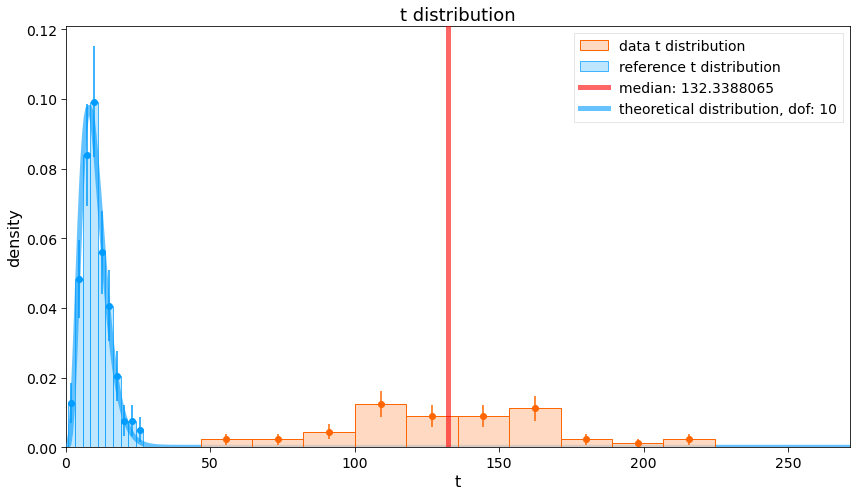

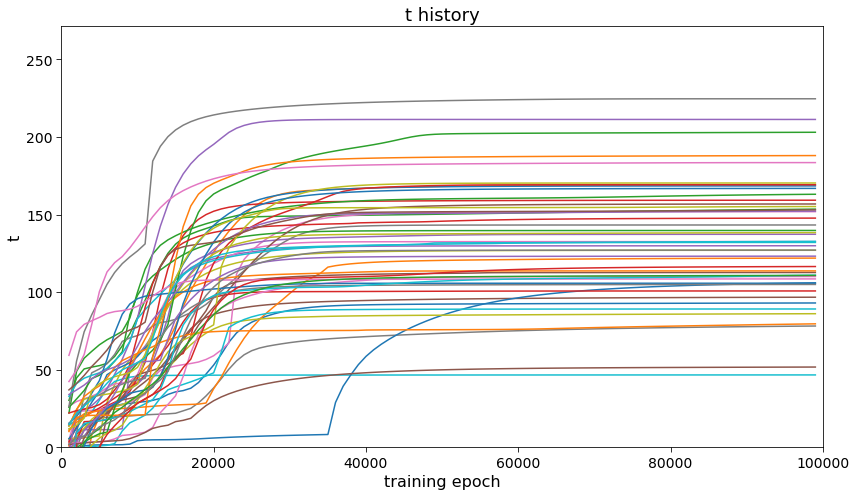

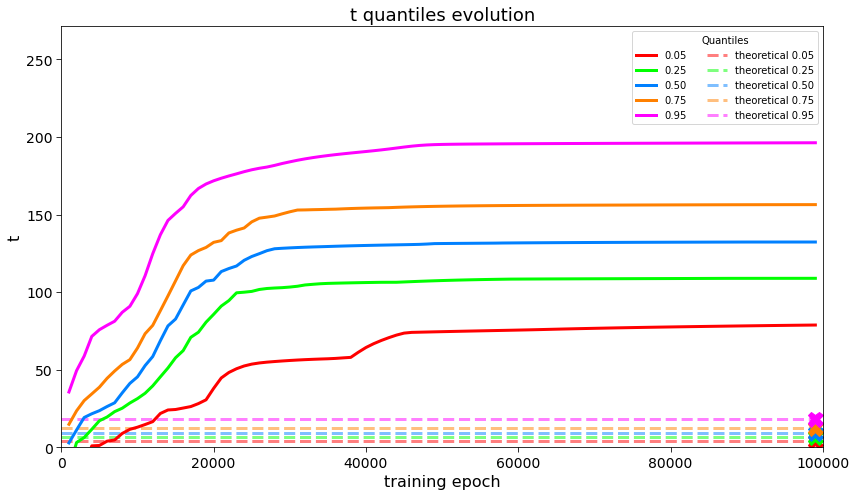

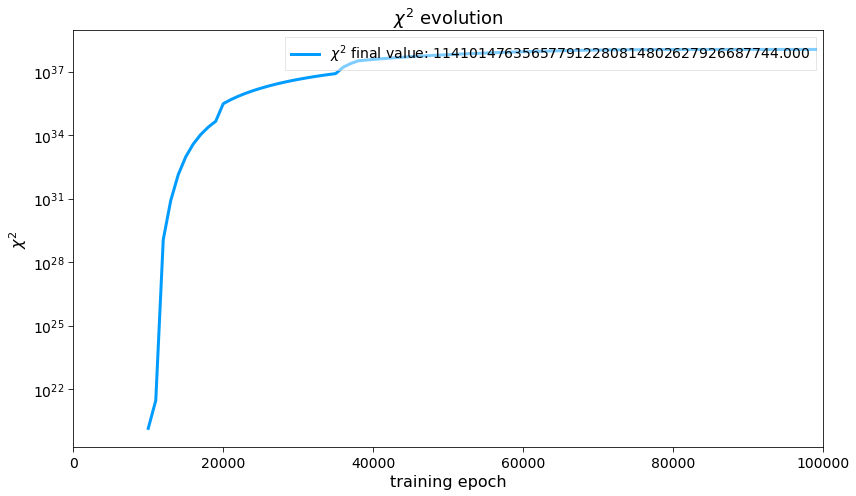

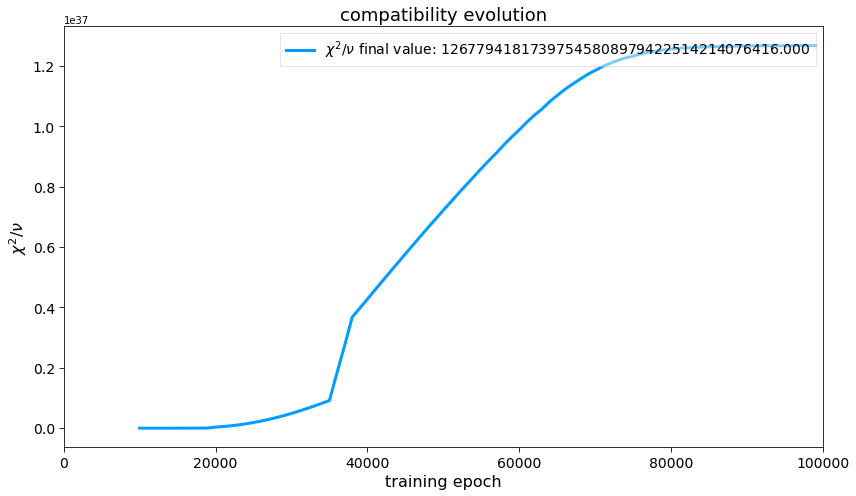

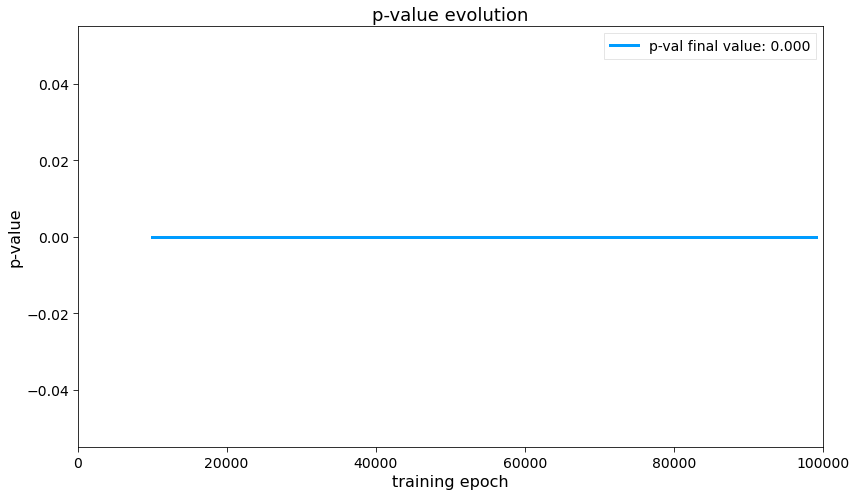

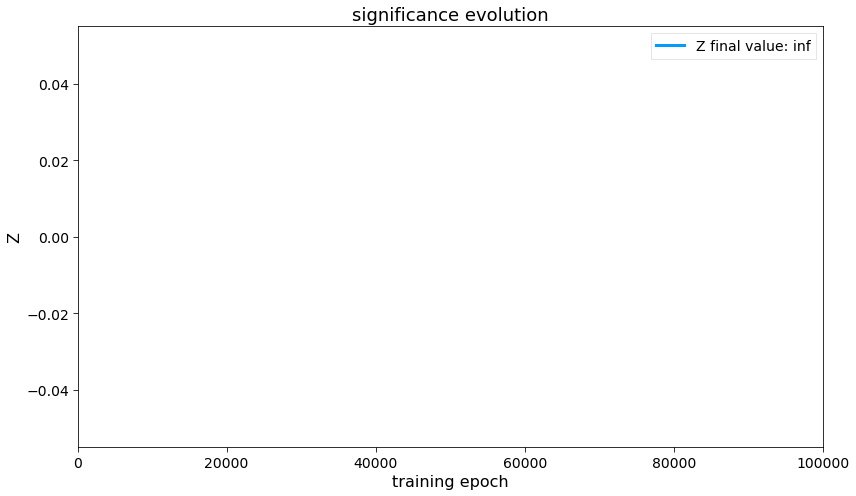

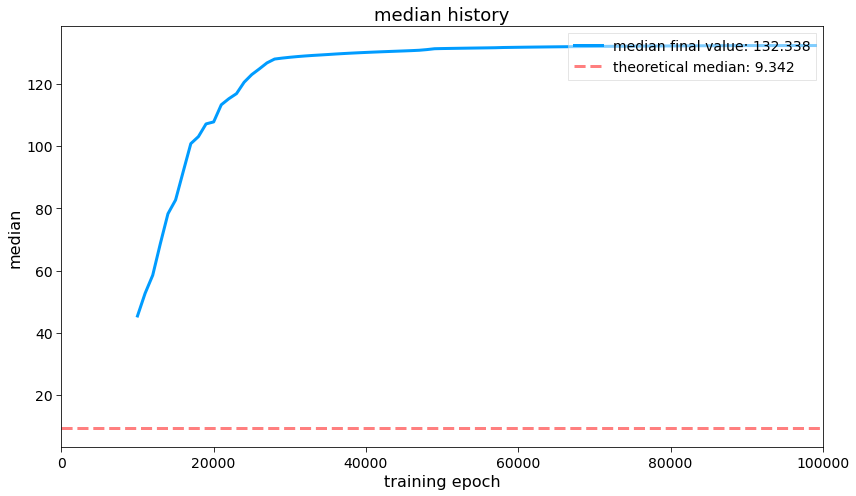

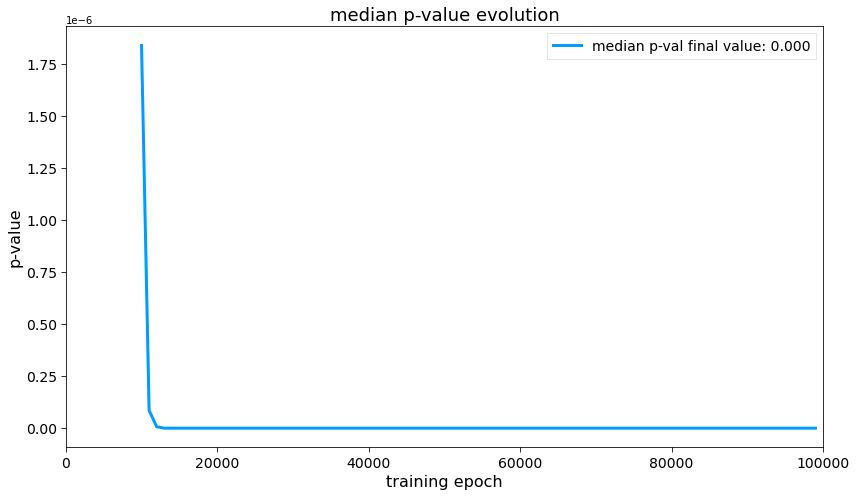

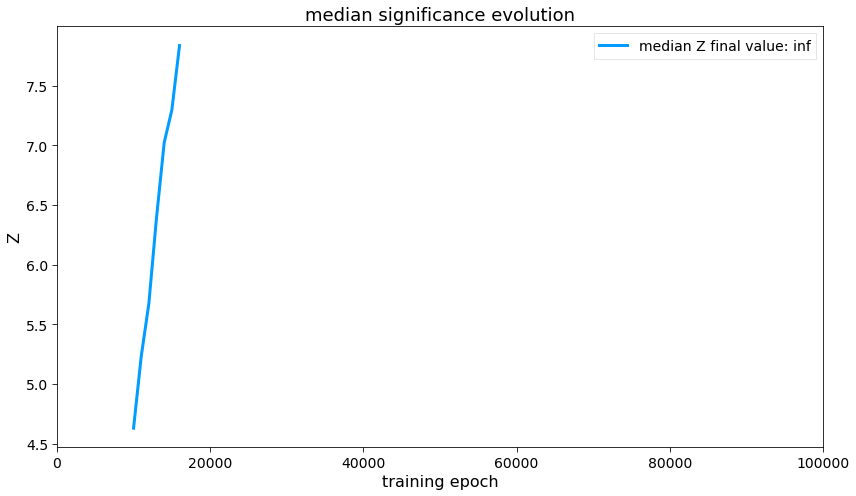

In [31]:
tDist.plotTdist(getTtrain())
tDist.plotThistory()
tDist.plotQuantilesEvo()
tDist.plotChi2History()
tDist.plotChi2Compatibility()
tDist.plotPValHistory()
tDist.plotSignificanceHistory()
# tDist.plotSignificanceToyhistory()
# tDist.plotSignificanceToyDistribution()
tDist.plotMedianHistory()
tDist.plotMedianPval()
tDist.plotMedianZ()

## Reference and Sig+Bkg Distributions

In [7]:
plt.rcParams['figure.figsize'] = [12, 8]

In [8]:
def BuildSample(FILE_NAME, n):
     
    df=pd.read_csv(FILE_NAME)
    df=df.sample(n=n)
    
    return df

def BuildDistribution(nbkg, nsig):
     
    bkg = scipy.stats.expon.rvs(loc=0,scale=0.125, size=nbkg)
    sig = scipy.stats.norm.rvs(loc=0.8,scale=0.02, size=nsig)
    data = np.concatenate((np.array(bkg), np.array(sig)))
    np.random.shuffle(data)
    df = pd.DataFrame({'feature0':data})

    return df

In [9]:
INPUT_PATH_REF = '/lustre/cmswork/nlai/NPL_CODE/1D/TEST/ref.txt' 

In [10]:
N_Sig = 20
N_Bkg = 10000 
N_Ref = 100000

In [11]:
N_Sig_P = np.random.poisson(lam=N_Sig, size=1)
N_Sig_p = N_Sig_P[0]
print('N_Sig: '+str(N_Sig))
print('N_Sig_Pois: '+str(N_Sig_p))

N_Bkg_P = np.random.poisson(lam=N_Bkg, size=1)
N_Bkg_p = N_Bkg_P[0]
print('N_Bkg: '+str(N_Bkg))
print('N_Bkg_Pois: '+str(N_Bkg_p))

N_Sig: 20
N_Sig_Pois: 15
N_Bkg: 10000
N_Bkg_Pois: 10249


In [12]:
# REFERENCE
HLF_REF = BuildSample(FILE_NAME=INPUT_PATH_REF, n=N_Ref)
print('Reference DF shape:')
print(HLF_REF.shape)

# SIGNAL+BACKGROUND DISTRIBUTION 
HLF_SIG = BuildDistribution(nbkg=N_Bkg_p, nsig=N_Sig_p)
print('Signal DF shape:')
print(HLF_SIG.shape)

Reference DF shape:
(100000, 1)
Signal DF shape:
(10264, 1)


In [13]:
#TARGETS
target_REF = np.zeros(N_Ref)
target_DATA = np.ones(N_Bkg_p+N_Sig_p)
target = np.append(target_REF, target_DATA)
target = np.expand_dims(target, axis=1)
print('target shape:')
print(target.shape)

target shape:
(110264, 1)


In [14]:
feature = np.concatenate((HLF_REF, HLF_SIG), axis=0)
feature = np.concatenate((feature, target), axis=1)
print('feature shape:')
print(feature.shape)

feature shape:
(110264, 2)


In [15]:
np.random.shuffle(feature)
dataF = pd.DataFrame({'feature':feature[:, 0], 'target':feature[:, -1]})
dataF.loc[(dataF['target']==0, 'Distribution')] = 'REF'
dataF.loc[(dataF['target']==1, 'Distribution')] = 'DATA'
dataF.head(10)

,feature,target,Distribution
0,0.187555,0.0,REF
1,0.346003,0.0,REF
2,0.170578,0.0,REF
3,0.070507,0.0,REF
4,0.205595,0.0,REF
5,0.046791,0.0,REF
6,0.648948,0.0,REF
7,0.067749,0.0,REF
8,0.148220,0.0,REF
9,0.017222,0.0,REF


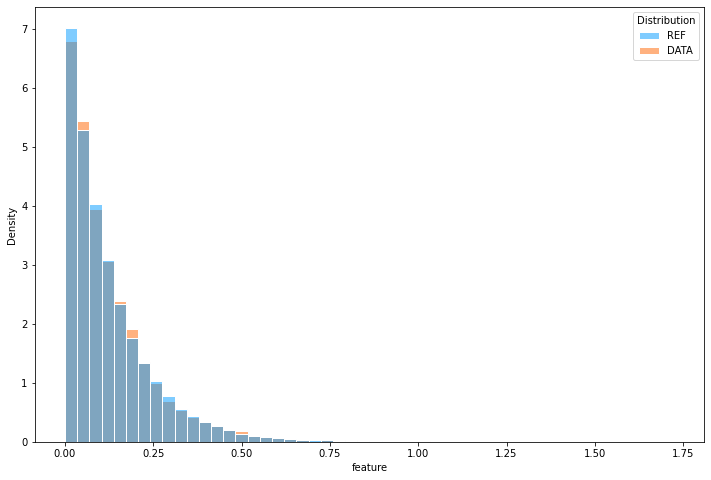

In [16]:
sns.histplot(data=dataF, x='feature', hue='Distribution', stat='density', element='bars', fill=True, common_norm=False,
             common_bins=True, bins = 50, palette=['#009AFF', '#ff6500'], edgecolor='white', multiple='layer', )
plt.show()